## **Imports**

In [1]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import re
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import matplotlib.pyplot as plt
from torch.nn import MSELoss
import shap

## **Data Preprocessing**

In [2]:
# Load the dataset
dataset = pd.read_csv('battery_feature_extracted.csv')

In [3]:
# Select features and target
X = dataset.drop(columns=['average_voltage'])
y = dataset['average_voltage']

In [4]:
# First split to separate out the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Second split: separate the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 20% for validation


In [6]:
# Standardizing the features (fit on X_train, apply to all)
scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)  # Ensure target tensor is of the right shape
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

In [8]:
# Model parameters
num_features = X_train_scaled.shape[1]
output_size = 1  # For regression, we predict a single continuous value

# Base Transformer Model - Composite Loss

In [9]:
# Define the TabTransformer model for regression
class TabTransformer(nn.Module):
    def __init__(self, num_features, output_size=1, dim_embedding=64, num_heads=4, num_layers=4, dropout=0.1):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(dim_embedding, output_size)

    def forward(self, x):
        x = self.embedding(x)  # Feature embedding
        x = x.unsqueeze(1)  # Add a sequence dimension
        x = self.transformer(x)  # Pass through the Transformer encoder
        x = torch.mean(x, dim=1)  # Aggregate over the sequence dimension
        x = self.regressor(x)  # Predict output
        return x

In [10]:
# Initialize the model, loss, and optimizer
model = TabTransformer(
    num_features=num_features,  # Input features
    output_size=output_size,    # Output size for regression
    dim_embedding=128,          # Embedding dimension
    num_heads=2,                # Number of attention heads
    num_layers=2,               # Number of transformer layers
    dropout=0.2                 # Dropout rate
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [11]:
# Define the composite loss function
class CompositeLoss(nn.Module):
    def __init__(self):
        super(CompositeLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
    
    def forward(self, outputs, targets):
        mse = self.mse_loss(outputs, targets)
        mae = self.mae_loss(outputs, targets)
        return mse + 0.6 * mae  # Adjust the weight (0.6 here) as needed

In [12]:
# Replace the loss function with CompositeLoss
criterion = CompositeLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00075)

In [13]:
# Training loop
training_losses = []
validation_losses = []

In [14]:
for epoch in range(2000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    train_loss = criterion(output, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)

    # Store the losses for plotting
    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())

    # Print training and validation loss every 10 epochs
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')


Epoch 0, Training Loss: 16.237319946289062, Validation Loss: 3.7176504135131836
Epoch 200, Training Loss: 1.4368648529052734, Validation Loss: 1.011103630065918
Epoch 400, Training Loss: 0.9881054162979126, Validation Loss: 0.7892667055130005
Epoch 600, Training Loss: 0.649042010307312, Validation Loss: 0.7241752743721008
Epoch 800, Training Loss: 0.3088752031326294, Validation Loss: 0.747337281703949
Epoch 1000, Training Loss: 0.1783919334411621, Validation Loss: 0.6925983428955078
Epoch 1200, Training Loss: 0.10619240999221802, Validation Loss: 0.7550275921821594
Epoch 1400, Training Loss: 0.10213920474052429, Validation Loss: 0.6965289115905762
Epoch 1600, Training Loss: 0.0770108699798584, Validation Loss: 0.7743550539016724
Epoch 1800, Training Loss: 0.078943632543087, Validation Loss: 0.7733162045478821


**SHAP**

In [20]:
# Step 1: Prepare your model and move to CPU
model.eval()
device = torch.device('cpu')
model = model.to(device)

# Step 2: Define the wrapped model
def wrapped_model(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(x_tensor).cpu().numpy()
    return preds

# Step 3: Prepare SHAP input data
X_train_np = X_train_scaled  # Already a NumPy array
X_test_np = X_test_scaled

# Reduce data for SHAP to save memory
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]  
X_sample = X_test_np[:200]  

# Step 4: Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(wrapped_model, background)

# Step 5: Compute SHAP values
shap_values = explainer.shap_values(X_sample)  # Avoid passing `nsamples` which causes errors

  0%|          | 0/200 [00:00<?, ?it/s]

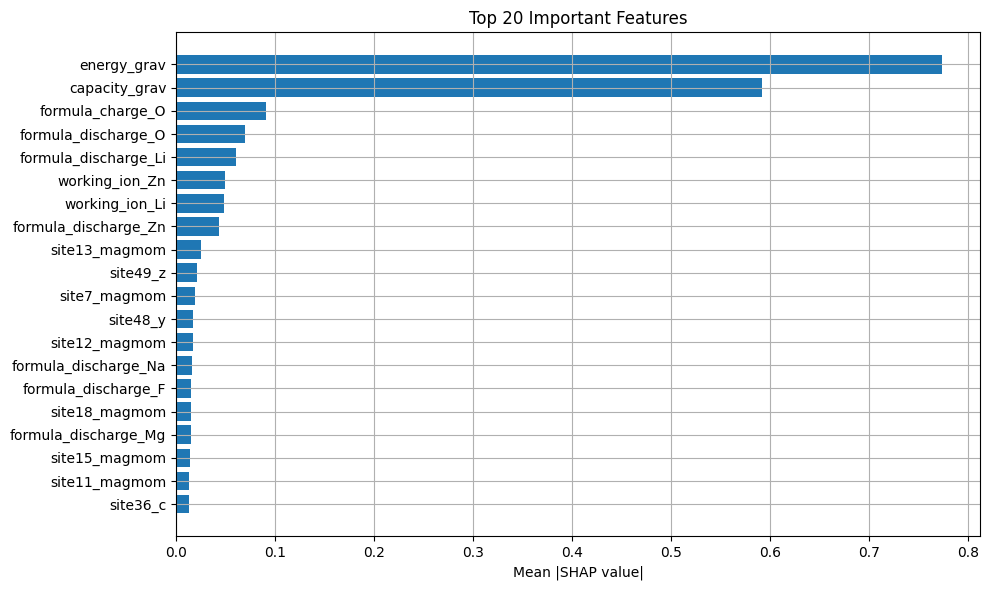

In [19]:
# Step 6: Feature importance summary
shap_array = shap_values.squeeze(-1)  # shape: (samples, features)
mean_abs_shap = np.abs(shap_array).mean(axis=0)

top_indices = np.argsort(mean_abs_shap)[-20:][::-1]
feature_names = X.columns.tolist()
top_features = [feature_names[i] for i in top_indices]
top_shap_values = mean_abs_shap[top_indices]

# Step 7: Plot Top 20 Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_shap_values)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()